In [1]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image
from torchvision import  transforms, models
from torch import nn
from XrayDataset import XrayDataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import torch
import matplotlib.pyplot as plt
import numpy as np




Bad key "text.kerning_factor" on line 4 in
/home/ramkik/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [22]:
classes = ['normal', 'COVID-19', 'other_pneumonia']

In [2]:
checkpoint = 'checkpoint1'

In [3]:
model = models.resnet50(pretrained=True)

In [4]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3))

In [5]:
transform = transforms.Compose([transforms.Grayscale(3),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor()
                                     
                                      ])

normalize =  transforms.Normalize(mean=[0.5], std=[0.5])
   

combined = transforms.Compose([transform, normalize])


In [6]:
train_dataset = XrayDataset( 'data', 'train', 'train.csv', transform )

test_dataset = XrayDataset('data', 'test', 'test.csv', transform )

In [7]:
batch_size = 1

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,  shuffle=False, num_workers=4)

In [9]:

configs = [
    dict(model_type='resnet', arch=model, layer_name='layer4'),
]

In [10]:
for config in configs:
    config['arch'].cuda().eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

normal
other_pneumonia
normal
COVID-19
normal
other_pneumonia
other_pneumonia
normal
other_pneumonia
other_pneumonia
normal
COVID-19
other_pneumonia
COVID-19
other_pneumonia
normal
normal
other_pneumonia
normal
other_pneumonia
normal
normal
20


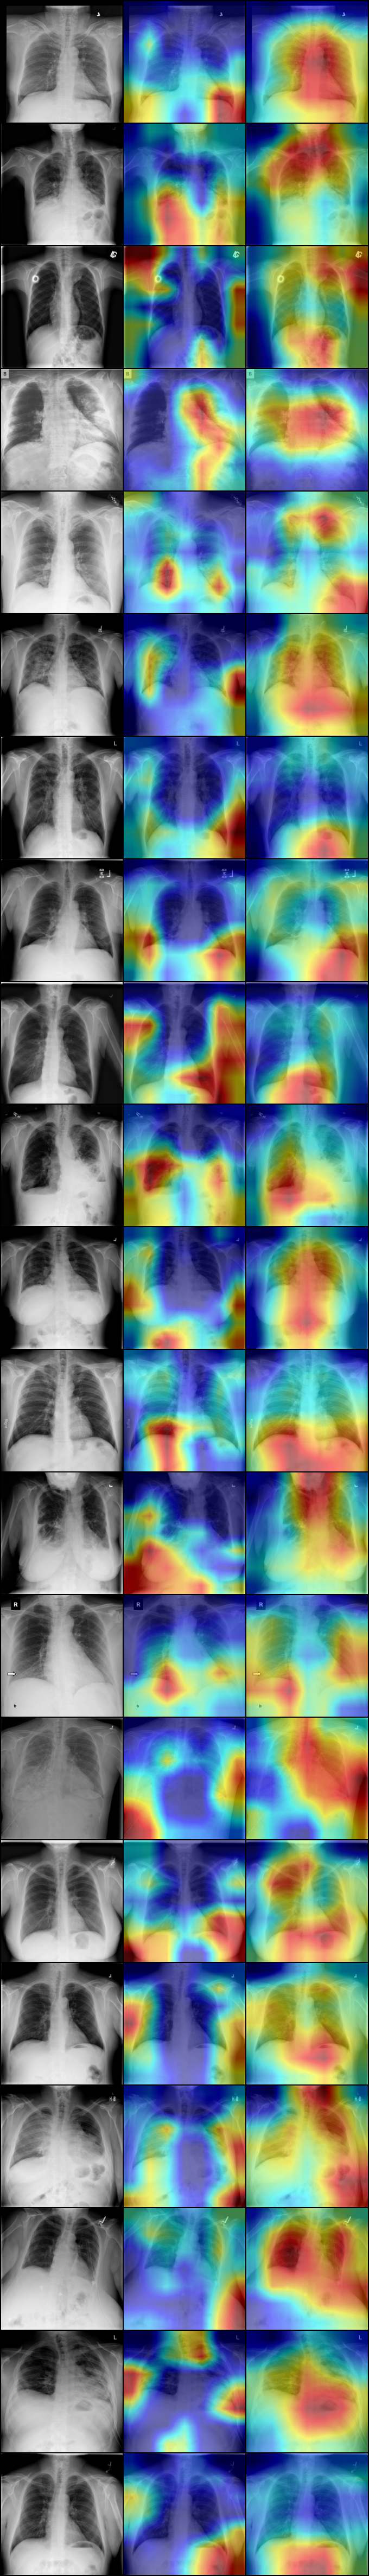

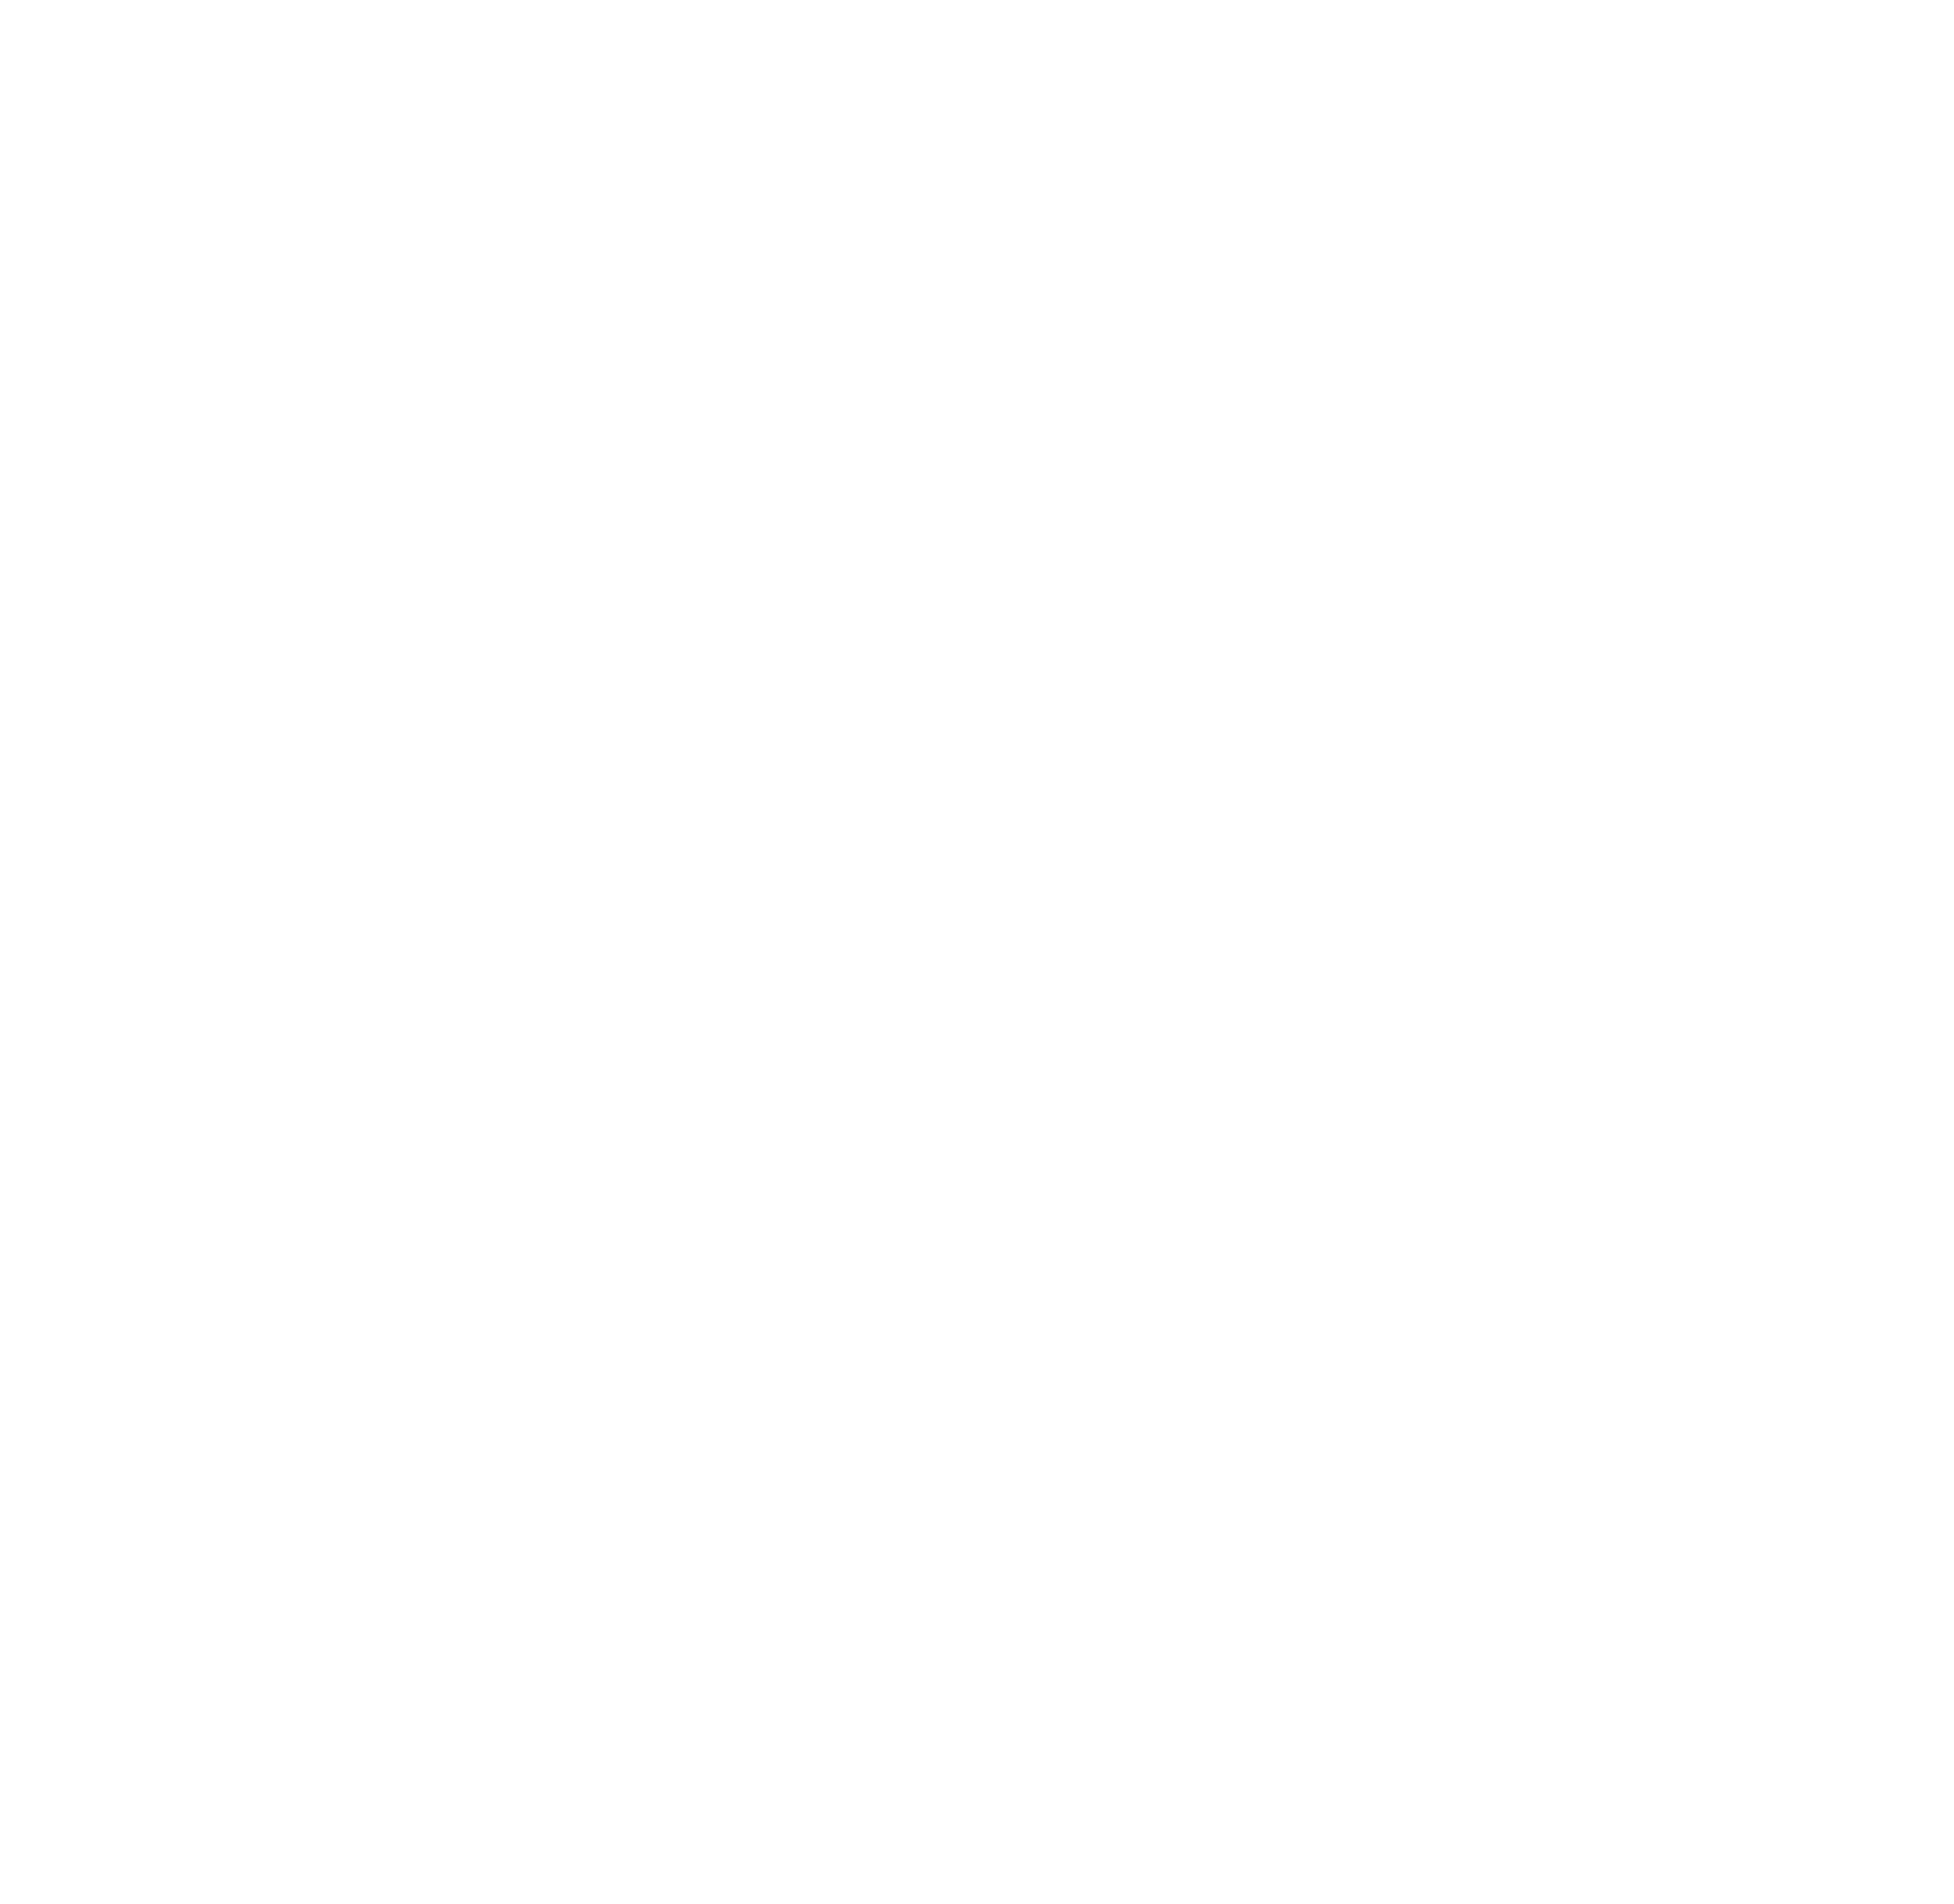

In [23]:
fig,axes = plt.subplots(nrows = 11, ncols = 1, figsize=(50,50))

for ax in axes.flatten():
    ax.axis('off')
    
a = False
count = -1

images = []

for inputs, labels in train_dataloader:
    print(classes[labels])
    if a==True:
        break
    count += 1
    if count==20:
        a= True
    inputs.squeeze_(0)
    #print(inputs.shape)

    normalizd = normalize(inputs)
    normalizd.unsqueeze_(0)
    if torch.cuda.is_available():
            normalizd, labels = normalizd.cuda(), labels.cuda()
            
    
    for gradcam, gradcam_pp in cams:
        mask, _ = gradcam(normalizd)
        heatmap, result = visualize_cam(mask, inputs)

        mask_pp, _ = gradcam_pp(normalizd)
        heatmap_pp, result_pp = visualize_cam(mask_pp, inputs)

        images.extend([inputs, result, result_pp])

#     for i in images:
#         print(i.shape)
grid_image = make_grid(images, nrow=3)
print(count)
#axes[count].imshow(grid_image.permute(1, 2, 0))
transforms.ToPILImage()(grid_image)
#plt.imshow(np.transpose(grid_image, (1,2,0)))
#plt.show()